In [1]:
import pickle

# Load the pickle file
with open(f"../scenario-properties-collision.pkl", "rb") as f:
    scenario_properties = pickle.load(f)


/opt/anaconda3/envs/opus-env/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from utils.simulation.scen_properties import ScenarioProperties


class SEPDataExport:
    """
    Export population and collision data from SEP simulations.

    Creates:
      - pop_time.csv            (total population over time)
      - pop_time_alt.csv        (population by altitude over time)
      - heatmaps/               (heatmap PNGs per species)
      - pairwise_collisions_time_alt.csv (if indicator variables available)
    """

    def __init__(self,
                 scenario_properties: ScenarioProperties,
                 simulation_name: str,
                 elliptical: bool,
                 MOCAT_MC_Path: str = None,
                 output_dir: str = None):
        self.scenario_properties = scenario_properties
        self.simulation_name = simulation_name
        self.MOCAT_MC_Path = MOCAT_MC_Path
        # Base directory for CSVs and figures
        self.base_path = output_dir or f"figures/{simulation_name}"
        os.makedirs(self.base_path, exist_ok=True)
        # Directory for heatmaps
        self.heatmap_dir = os.path.join(self.base_path, "heatmaps")
        os.makedirs(self.heatmap_dir, exist_ok=True)

        # Load simulation outputs
        sp = self.scenario_properties
        self.Hmid = sp.HMid                # [n_shells]
        self.start_year = pd.to_datetime(sp.start_date).year
        self.species = sp.species_names    # list[str]
        self.n_shells = sp.n_shells
        self.times = sp.scen_times         # list[float]
        self.y = sp.output.y               # array shape [n_species*n_shells, n_times]
        # Optional: large fragments list for grouping
        self.large_fragments = ['N_10kg', 'N_148kg', 'N_260kg', 'N_472kg', 'N_750kg', 'N_1250kg'] #getattr(sp, 'large_fragments', [])

        if elliptical:
            self.pop_time_df, self.pop_time_alt_df, self.pop_time_df_grouped, self.pop_time_alt_df_grouped = self.elliptical_to_effective_altitude_bins()
            # self.generate_heatmaps(self.pop_time_alt_df_grouped)
        else: 
            self.pop_time()
            self.pop_time_alt()
            self.generate_heatmaps()

            snapshot_years = [2025, 2050, 2075, 2100, 2125]

            self.export_snapshots(snapshot_years=snapshot_years)

            if scenario_properties.indicator_results is not None:
                self.plot_cumulative_collisions_by_prefix()
                self.plot_cumulative_indicator()
                self.plot_cumulative_pairwise_by_species()
                self.export_pairwise_collisions_time_alt()
        
        if MOCAT_MC_Path:
            self.grouped_population_mc_comparison(self.pop_time_df_grouped)


    def _group_label(self, sp: str) -> str:
        """
        Determine group label from species code.
        """
        if sp.startswith('Sns'):
            return 'Sns'
        if sp.startswith('Su'):
            return 'Su'
        if sp.startswith('S'):
            return 'S'
        if sp == 'B':
            return 'B'
        if sp in self.large_fragments:
            return 'D'
        return 'N'

    def pop_time(self) -> pd.DataFrame:
        """
        Export total population per species over time to pop_time.csv.
        """
        rows = []
        for i, sp in enumerate(self.species):
            label = self._group_label(sp)
            start_idx = i * self.n_shells
            end_idx = (i + 1) * self.n_shells
            if end_idx > self.y.shape[0]:
                continue
            shell_data = self.y[start_idx:end_idx, :]
            # sum over shells for each time step
            for t_idx, offset in enumerate(self.times):
                year = int(self.start_year + offset)
                pop = shell_data[:, t_idx].sum()
                rows.append({
                    "Species": label,
                    "Year": year,
                    "Population": pop
                })

        df = pd.DataFrame(rows)
        df_grouped = (
            df
            .groupby(["Species", "Year"], as_index=False)
            .sum()
            .sort_values(["Species", "Year"])  
            .reset_index(drop=True)
        )
        path = os.path.join(self.base_path, "pop_time.csv")
        df_grouped.to_csv(path, index=False)
        print(f"Saved total population over time to {path}")
        return df_grouped

    def pop_time_alt(self) -> pd.DataFrame:
        """
        Export shell-resolved population per species over time and altitude to pop_time_alt.csv.
        """
        rows = []
        for i, sp in enumerate(self.species):
            label = self._group_label(sp)
            start_idx = i * self.n_shells
            end_idx = (i + 1) * self.n_shells
            if end_idx > self.y.shape[0]:
                continue
            shell_block = self.y[start_idx:end_idx, :]
            for s in range(self.n_shells):
                alt = self.Hmid[s]
                for t_idx, offset in enumerate(self.times):
                    year = int(self.start_year + offset)
                    pop = shell_block[s, t_idx]
                    rows.append({
                        "Species": label,
                        "Year": year,
                        "Altitude": alt,
                        "Population": pop
                    })

        df = pd.DataFrame(rows)
        df_grouped = (
            df
            .groupby(["Species", "Year", "Altitude"], as_index=False)
            .sum()
            .sort_values(["Species", "Year", "Altitude"] )
            .reset_index(drop=True)
        )
        path = os.path.join(self.base_path, "pop_time_alt.csv")
        df_grouped.to_csv(path, index=False)
        print(f"Saved altitude-resolved population data to {path}")
        return df_grouped

    def generate_heatmaps(self, df_alt: pd.DataFrame = None):
        """
        Generate and save heatmaps for each species using the altitude-resolved data.
        """
        if df_alt is None:
            df_alt = self.pop_time_alt()

        for sp in df_alt["Species"].unique():
            df_sp = df_alt[df_alt["Species"] == sp]
            pivot = df_sp.pivot_table(
                index="Altitude", columns="Year", values="Population",
                aggfunc="sum", fill_value=0
            )
            plt.figure(figsize=(12, 6))
            sns.heatmap(pivot, cmap="viridis", cbar_kws={'label': 'Population'})
            plt.gca().invert_yaxis()
            plt.title(f"Population Heatmap for Species: {sp}")
            plt.xlabel("Year")
            plt.ylabel("Altitude (km)")
            plt.tight_layout()

            fname = os.path.join(self.heatmap_dir, f"{sp}_heatmap.png")
            plt.savefig(fname, dpi=300)
            plt.close()
            print(f"Saved heatmap for {sp} to {fname}")

    def export_snapshots(self,
                         snapshot_years: list[int] = None
                         ) -> pd.DataFrame:
        """
        For each year in `snapshot_years`, save:
          1. A bar chart of total population per species.
          2. Line plots of population vs. altitude per species.
          3. A CSV of the filtered snapshot data.
        Returns the DataFrame of snapshot rows.
        """
        import matplotlib.pyplot as plt

        # default snapshots if none provided
        if snapshot_years is None:
            snapshot_years = [2025, 2050, 2075, 2100, 2125]

        # make sure we have the altitude-resolved table
        df_alt = self.pop_time_alt()

        # filter
        df_snap = df_alt[df_alt["Year"].isin(snapshot_years)]

        # 1. bar chart
        bar_data = (
            df_snap
            .groupby(["Year", "Species"])["Population"]
            .sum()
            .unstack(fill_value=0)
        )
        fig, ax = plt.subplots(figsize=(10, 6))
        bar_data.plot(kind="bar", ax=ax)
        ax.set_ylabel("Total Population")
        ax.set_title("Snapshot: Total Population per Species")
        ax.set_xticklabels(bar_data.index, rotation=0)
        plt.tight_layout()
        bar_path = os.path.join(self.base_path, "pop_snapshot_bar.png")
        fig.savefig(bar_path, dpi=300)
        plt.close(fig)
        print(f"✅ Saved bar chart snapshot to {bar_path}")

        # 2. fixed line plots by altitude
        line_dir = os.path.join(self.base_path, "snapshots_altitude_lines")
        os.makedirs(line_dir, exist_ok=True)
        for year in snapshot_years:
            fig, ax = plt.subplots(figsize=(10, 6))
            df_y = df_snap[df_snap["Year"] == year]
            alts = sorted(df_y["Altitude"].unique())
            for sp in sorted(df_y["Species"].unique()):
                df_sp = (
                    df_y[df_y["Species"] == sp]
                    .groupby("Altitude", as_index=False)["Population"]
                    .sum()
                    .set_index("Altitude")
                    .reindex(alts, fill_value=0)
                    .reset_index()
                )
                ax.plot(df_sp["Altitude"], df_sp["Population"],
                        marker="o", linestyle="-", label=sp)
            ax.set_title(f"Population by Altitude – {year}")
            ax.set_xlabel("Altitude (km)")
            ax.set_ylabel("Population")
            ax.legend()
            ax.grid(True)
            plt.tight_layout()
            path = os.path.join(line_dir, f"pop_by_altitude_{year}.png")
            fig.savefig(path, dpi=300)
            plt.close(fig)
            print(f"✅ Saved line plot for {year} to {path}")

        # 3. save snapshot CSV
        csv_path = os.path.join(self.base_path, "pop_snapshots.csv")
        df_snap.to_csv(csv_path, index=False)
        print(f"✅ Saved snapshot data to {csv_path}")

        return df_snap
    
    def plot_cumulative_indicator(self, indicator_name: str = None) -> np.ndarray:
        """
        Generate & save a cumulative‐indicator vs time line plot.
        If no name given, uses the last indicator in scenario_properties.indicator_results.
        Returns the cumulative array.
        """
        import os, numpy as np, matplotlib.pyplot as plt

        inds = self.scenario_properties.indicator_results['indicators']
        if indicator_name is None:
            indicator_name = list(inds.keys())[-1]
        data = inds[indicator_name]

        times = np.array(list(data.keys()))
        mat   = np.array([np.squeeze(v) for v in data.values()])  # [t, shells]
        total = mat.sum(axis=1)
        cum   = np.cumsum(total)

        fig, ax = plt.subplots(figsize=(10,5))
        ax.plot(times, cum, marker='o')
        ax.set_xlabel("Time")
        ax.set_ylabel("Cumulative Indicator Value")
        ax.set_title(f"Cumulative Indicator: {indicator_name}")
        ax.grid(True)
        plt.tight_layout()

        out = os.path.join(self.base_path, f"cumulative_indicator_{indicator_name}.png")
        fig.savefig(out, dpi=300)
        plt.close(fig)
        print(f"✅ Saved cumulative indicator plot to {out}")

        return cum

    def plot_cumulative_collisions_by_prefix(self) -> tuple[np.ndarray, dict]:
        inds = {
            n: d for n, d in self.scenario_properties.indicator_results.get('indicators', {}).items()
            if n.endswith('aggregate_collisions') and n != 'active_aggregate_collisions'
        }
        sum_by = {'N': None, 'S': None, 'B': None}
        times = None
        for name, data_dict in inds.items():
            prefix = name.split('_')[0]
            if prefix not in sum_by:
                continue
            arr = np.vstack([np.squeeze(v) for v in data_dict.values()])
            tsum = arr.sum(axis=1)
            if times is None:
                times = np.array(list(data_dict.keys()))
            if sum_by[prefix] is None:
                sum_by[prefix] = tsum.copy()
            else:
                sum_by[prefix] = sum_by[prefix] + tsum
        if times is None:
            raise ValueError("No aggregate_collisions indicators found.")
        total = None
        for arr in sum_by.values():
            if arr is None:
                continue
            total = arr.copy() if total is None else total + arr
        if total is None:
            raise ValueError("No collision data to plot.")
        total_cum = np.cumsum(total)
        cum_by = {p: np.cumsum(v) for p, v in sum_by.items() if v is not None}

        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(times, total_cum, label='Total Collisions', linewidth=2)
        for p, c in cum_by.items():
            ax.plot(times, c, label=p)
        ax.set_xlabel("Time")
        ax.set_ylabel("Cumulative Collisions")
        ax.set_title("Cumulative Aggregate Collisions by Class")
        ax.legend()
        ax.grid(True)
        plt.tight_layout()

        out = os.path.join(self.base_path, "cumulative_collisions_by_prefix.png")
        fig.savefig(out, dpi=300)
        plt.close(fig)
        print(f"Saved cumulative collisions by prefix to {out}")
        return total_cum, cum_by

    def plot_cumulative_pairwise_by_species(self) -> dict:
        """
        Sum all 'pair_collisions' by starting‐species prefix (N, S, Su, Sns, B)
        and plot their cumulative collisions over time.
        Returns the dict of cumulative arrays.
        """
        import os
        import numpy as np
        import matplotlib.pyplot as plt

        inds = {
            n: d for n, d in self.scenario_properties.indicator_results.get('indicators', {}).items()
            if 'pair_collisions' in n
        }
        prefixes = ['N', 'S', 'Su', 'Sns', 'B']
        times = None
        cum_by = {}

        for pref in prefixes:
            agg = None
            for name, data_dict in inds.items():
                base = name.replace('_pair_collisions', '').split('__')[0]
                if not base.startswith(pref):
                    continue
                arr = np.vstack([np.squeeze(v) for v in data_dict.values()])
                tsum = arr.sum(axis=1)
                # only set times once, avoid ambiguous truth test on array
                if times is None:
                    times = np.array(list(data_dict.keys()))
                agg = tsum.copy() if agg is None else agg + tsum
            if agg is not None:
                cum_by[pref] = np.cumsum(agg)

        if not cum_by:
            raise ValueError("No pairwise collision indicators found.")

        fig, ax = plt.subplots(figsize=(12, 6))
        for p, c in cum_by.items():
            ax.plot(times, c, label=p)
        ax.set_xlabel("Time")
        ax.set_ylabel("Cumulative Pairwise Collisions")
        ax.set_title("Cumulative Pairwise Collisions by Starting Species")
        ax.legend()
        ax.grid(True)
        plt.tight_layout()

        out = os.path.join(self.base_path, "cumulative_pairwise_by_species.png")
        fig.savefig(out, dpi=300)
        plt.close(fig)
        print(f"Saved cumulative pairwise by species to {out}")
        return cum_by

    def export_pairwise_collisions_time_alt(self) -> pd.DataFrame:
        """
        Build & save `pairwise_collisions_time_alt.csv`, then
        generate a heatmap per species-pair (Year vs Altitude).
        """
        import os
        import numpy as np
        import matplotlib.pyplot as plt
        import seaborn as sns
        from collections import defaultdict

        # --- build the flat table ---
        Hmid = self.Hmid
        sy   = self.start_year
        lf   = self.large_fragments

        def grp(n):
            if n in lf:        return 'D'
            if n.startswith('Sns'): return 'Sns'
            if n.startswith('Su'):  return 'Su'
            if n.startswith('S'):   return 'S'
            if n == 'B':       return 'B'
            return 'N'

        inds = {
            name: data
            for name, data in self.scenario_properties.indicator_results
                                .get('indicators', {}).items()
            if name.endswith('pair_collisions')
        }
        if not inds:
            raise ValueError("No pairwise collision indicators to export.")

        rows = []
        for fullname, data_dict in inds.items():
            raw1, raw2 = fullname.replace('_pair_collisions','').split('__')
            s1, s2 = grp(raw1), grp(raw2)
            for offset, arr in data_dict.items():
                year = int(sy + offset)
                vals = np.squeeze(arr)
                # handle 0-D vs 1-D
                for idx, v in enumerate(vals if vals.ndim else [vals]):
                    rows.append({
                        "Species 1": s1,
                        "Species 2": s2,
                        "Year": year,
                        "Altitude": Hmid[idx],
                        "Collisions": v
                    })

        df = pd.DataFrame(rows)\
            .sort_values(["Species 1", "Species 2", "Year", "Altitude"])\
            .reset_index(drop=True)

        # --- write CSV ---
        csv_path = os.path.join(self.base_path, "pairwise_collisions_time_alt.csv")
        df.to_csv(csv_path, index=False)
        print(f"✅ Saved pairwise collisions data to {csv_path}")

        # --- now generate heatmaps ---
        heat_dir = os.path.join(self.base_path, "pairwise_heatmaps")
        os.makedirs(heat_dir, exist_ok=True)

        # for each pair, pivot & plot
        pairs = df[["Species 1","Species 2"]].drop_duplicates().itertuples(index=False)
        for sp1, sp2 in pairs:
            sub = df[(df["Species 1"]==sp1)&(df["Species 2"]==sp2)]
            pivot = sub.pivot_table(
                index="Altitude",
                columns="Year",
                values="Collisions",
                aggfunc="sum",
                fill_value=0
            )
            fig, ax = plt.subplots(figsize=(10,6))
            sns.heatmap(pivot, cmap="viridis", cbar_kws={'label':'Collisions'}, ax=ax)
            ax.invert_yaxis()
            ax.set_title(f"Collisions: {sp1}–{sp2}")
            ax.set_xlabel("Year")
            ax.set_ylabel("Altitude (km)")
            plt.tight_layout()

            fname = os.path.join(heat_dir, f"{sp1}_{sp2}_heatmap.png")
            fig.savefig(fname, dpi=300)
            plt.close(fig)
            print(f"✅ Saved heatmap for {sp1}–{sp2} to {fname}")
    
    def elliptical_to_effective_altitude_bins(self):
        """
        Convert the raw SMA–species–eccentricity population array into
        effective populations per altitude shell over time, and store
        the result back into scenario_properties.output for reuse.

        On completion, sets:
        scenario_properties.output.y_alt       (shape [n_alt, n_species, n_time])
        scenario_properties.output.altitudes   (1-D array of Hmid)

        Returns:
            df_pop_time:       total population per species over time
            df_pop_time_alt:   altitude-resolved population per species over time
            df_group_time:     grouped species population per time
            df_group_time_alt: grouped species & altitude population per time
        """

        import numpy as np
        import pandas as pd
        import os

        sp = self.scenario_properties
        # --- Dimensions ---
        n_sma_bins    = sp.n_shells
        n_alt_shells  = sp.n_shells
        n_species     = sp.species_length
        n_ecc_bins    = len(sp.eccentricity_bins) - 1
        n_time        = sp.output.y.shape[1]
        times         = sp.output.t
        species_names = sp.species_names
        altitudes     = sp.HMid

        # --- Unpack population data ---
        y = sp.output.y
        x_full = y.reshape(n_sma_bins, n_species, n_ecc_bins, n_time)

        # --- Containers for rows ---
        pop_time_rows     = []
        pop_time_alt_rows = []

        # === Collect rows ===
        for t_idx, offset in enumerate(times):
            year = int(self.start_year + offset)
            # Build altitude_resolved for all species
            for s in range(n_species):
                pop_snapshot = x_full[:, s, :, t_idx]
                temp_full    = np.zeros((n_sma_bins, n_species, n_ecc_bins))
                temp_full[:, s, :] = pop_snapshot
                alt_proj     = sp.sma_ecc_mat_to_altitude_mat(temp_full)
                # altitude-resolved rows
                for alt_idx, alt in enumerate(altitudes):
                    pop_time_alt_rows.append({
                        "Species":    species_names[s],
                        "Year":       year,
                        "Altitude":   alt,
                        "Population": alt_proj[alt_idx, s]
                    })
            # total per species/year
            for s in range(n_species):
                total_pop = sum(r['Population'] for r in pop_time_alt_rows
                                if r['Species'] == species_names[s] and r['Year'] == year)
                pop_time_rows.append({
                    "Species":    species_names[s],
                    "Year":       year,
                    "Population": total_pop
                })

        # === Create DataFrames ===
        df_pop_time = pd.DataFrame(pop_time_rows)
        df_pop_time = (
            df_pop_time
            .groupby(["Species", "Year"], as_index=False).sum()
            .sort_values(["Species", "Year"]).reset_index(drop=True)
        )
        df_pop_time.to_csv(os.path.join(self.base_path, "pop_time.csv"), index=False)

        df_pop_time_alt = pd.DataFrame(pop_time_alt_rows)
        df_pop_time_alt = (
            df_pop_time_alt
            .groupby(["Species", "Year", "Altitude"], as_index=False).sum()
            .sort_values(["Species", "Year", "Altitude"]).reset_index(drop=True)
        )
        df_pop_time_alt.to_csv(os.path.join(self.base_path, "pop_time_alt.csv"), index=False)

        # === Define groupings ===
        large_fragments = ['N_10kg','N_148kg','N_260kg','N_472kg','N_750kg','N_1250kg']
        group_indices = {
            'S':   [i for i, spn in enumerate(species_names) if spn == 'S'],
            'Su':  [i for i, spn in enumerate(species_names) if spn == 'Su'],
            'Sns': [i for i, spn in enumerate(species_names) if spn == 'Sns'],
            'N':   [i for i, spn in enumerate(species_names) if spn.startswith('N') and spn not in large_fragments],
            'D':   [i for i, spn in enumerate(species_names) if spn in large_fragments],
            'B':   [i for i, spn in enumerate(species_names) if spn == 'B']
        }

        # === Grouped totals per year ===
        group_rows = []
        for group, inds in group_indices.items():
            names = [species_names[i] for i in inds]
            for year, sub in df_pop_time.groupby('Year'):
                total = sub[sub['Species'].isin(names)]['Population'].sum()
                group_rows.append({'Species': group, 'Year': year, 'Population': total})
        df_group_time = pd.DataFrame(group_rows).sort_values(['Species','Year']).reset_index(drop=True)
        df_group_time.to_csv(os.path.join(self.base_path, "pop_time_grouped.csv"), index=False)

        # === Grouped altitude-resolved per year ===
        group_alt_rows = []
        for group, inds in group_indices.items():
            names = [species_names[i] for i in inds]
            sub = df_pop_time_alt[df_pop_time_alt['Species'].isin(names)]
            for (year, alt), grp in sub.groupby(['Year','Altitude']):
                total = grp['Population'].sum()
                group_alt_rows.append({'Species': group, 'Year': year, 'Altitude': alt, 'Population': total})
        df_group_time_alt = pd.DataFrame(group_alt_rows).sort_values(['Species','Year','Altitude']).reset_index(drop=True)
        df_group_time_alt.to_csv(os.path.join(self.base_path, "pop_time_alt_grouped.csv"), index=False)

        return df_pop_time, df_pop_time_alt, df_group_time, df_group_time_alt
    
    def grouped_population_mc_comparison(self, df_group_time_alt=None):
            """
            Plot grouped SSEM vs MOCAT-MC population comparison for defined species groups.
            """
            pivot_ssem = df_group_time_alt.pivot(index='Year', columns='Species', values='Population')
            years = pivot_ssem.index.values

            # Load MOCAT-MC pop_time.csv
            mc_df = pd.read_csv(self.MOCAT_MC_Path)

            # Set up subplot grid
            species_groups = ['S', 'Su', 'Sns', 'N', 'D', 'B']
            fig, axes = plt.subplots(2, 3, figsize=(15,8), sharex=True)
            axes = axes.flatten()

            for ax, group in zip(axes, species_groups):
                # Plot SSEM
                if group in pivot_ssem.columns:
                    ax.plot(years, pivot_ssem[group], label='SSEM', linewidth=2)

                # Plot MC
                sub_mc = mc_df[mc_df['Species']==group]
                if not sub_mc.empty:
                    ax.plot(sub_mc['Year'], sub_mc['Population'],
                            '--', label='MC', linewidth=1.5)

                ax.set_title(group)
                ax.set_ylabel('Population')
                ax.grid(True)
                ax.legend()

            # Shared X labels
            axes[-2].set_xlabel('Year')
            axes[-1].set_xlabel('Year')

            plt.suptitle("SSEM vs MOCAT-MC: Grouped Population Over Time", fontsize=14)
            plt.tight_layout(rect=[0,0,1,0.95])

            out = os.path.join(self.base_path, 'grouped_population_comparison.png')
            plt.savefig(out, dpi=300)
            plt.close(fig)
            print(f"Saved comparison figure to {out}")

In [10]:
mc_pop_time_path = '/Users/indigobrownhall/Code/MOCAT-VnV/results/pop_time.csv'
sep = SEPDataExport(scenario_properties, "SEP2-FragSpread", elliptical=True, MOCAT_MC_Path=mc_pop_time_path)

Saved comparison figure to figures/SEP2-FragSpread/grouped_population_comparison.png


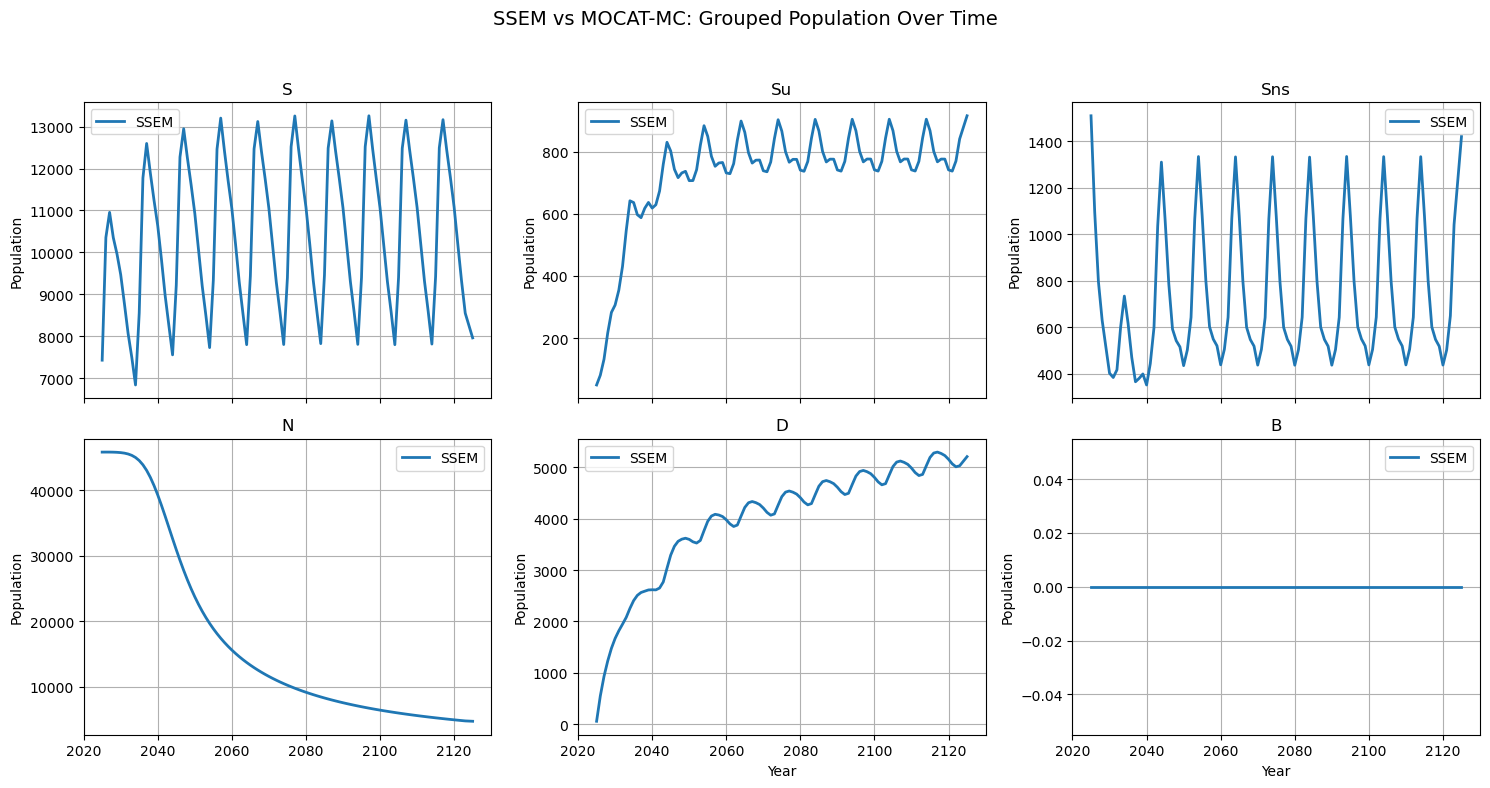

In [ ]:
# === Plot SSEM vs MOCAT-MC for selected groups ===
# Assuming Jupyter: data already loaded as sep.df_pop_alt and sep.df_pop_time
# Prepare DataFrames
if hasattr(sep, 'df_pop_time'):
    pop_time_df = sep.pop_time_df_grouped
if hasattr(sep, 'df_pop_alt'):
    pop_time_alt_df = sep.pop_time_alt_df_grouped

# Compute total per species-year for SSEM
ssem = sep.pop_time_df_grouped.copy()

# Define groups and grid
species_groups = ['S', 'Su', 'Sns', 'N', 'D', 'B']
start_year = scenario_properties.output.t[0] + sep.start_year  # first year
ssem_years = np.unique(ssem['Year'].values)

# Organize SSEM group totals
group_totals = {
    group: ssem[ssem['Species'] == group].set_index('Year')['Population'].reindex(ssem_years, fill_value=0).values
    for group in species_groups
}

# Assume mc_pop_time exists as DataFrame
mc_pop_time = globals().get('mc_pop_time', pd.DataFrame())

# Create comparison plot
n_rows, n_cols = 2, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8), sharex=True)
axes = axes.flatten()

for idx, group in enumerate(species_groups):
    ax = axes[idx]
    # Plot SSEM
    ax.plot(ssem_years, group_totals[group], label='SSEM', linewidth=2)
    # Plot MC
    if not mc_pop_time.empty and group in mc_pop_time['Species'].unique():
        mc_df = mc_pop_time[mc_pop_time['Species'] == group]
        ax.plot(mc_df['Year'], mc_df['Population'], '--', label='MC', linewidth=1.5)

    ax.set_title(group)
    ax.set_ylabel("Population")
    ax.grid(True)
    ax.legend()

# Shared X label
for ax in axes[-2:]:
    ax.set_xlabel("Year")

plt.suptitle("SSEM vs MOCAT-MC: Grouped Population Over Time", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.ticklabel_format(useOffset=False, axis='y')
plt.show()
